In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import cv2
import sys
import torch
from tqdm import tnrange

sys.path.insert(0, '..')
from adaptis.inference.adaptis_sampling import get_panoptic_segmentation
from adaptis.inference.prediction_model import AdaptISPrediction

device = torch.device('cuda:0')

### Init dataset

In [3]:
from adaptis.data.toy import ToyDataset

dataset_path = '/data/adaptis_toy_v2/'
dataset = ToyDataset(dataset_path, split='test', with_segmentation=True)

### Load model

In [4]:
from adaptis.model.toy.models import get_unet_model

model = get_unet_model(norm_layer=torch.nn.BatchNorm2d, with_proposals=True)
pmodel = AdaptISPrediction(model, dataset, device)

weights_path = '../experiments/toy_v2/toy_v2_unet/checkpoints/proposals_last_checkpoint.params'
pmodel.load_parameters(weights_path)

### Define evaluation function

In [5]:
from adaptis.coco.panoptic_metric import PQStat, pq_compute, print_pq_stat


def test_model(pmodel, dataset,
               sampling_algorithm, sampling_params,
               use_flip=False, cut_radius=-1):
    pq_stat = PQStat()
    categories = dataset._generate_coco_categories()
    categories = {x['id']: x for x in categories}

    for indx in tnrange(len(dataset)):
        sample = dataset.get_sample(indx)
        pred = get_panoptic_segmentation(pmodel, sample['image'],
                                         sampling_algorithm=sampling_algorithm,
                                         use_flip=use_flip, cut_radius=cut_radius, **sampling_params)
        
        
        coco_sample = dataset.convert_to_coco_format(sample)
        pred = dataset.convert_to_coco_format(pred)

        pq_stat = pq_compute(pq_stat, pred, coco_sample, categories)
    
    print_pq_stat(pq_stat, categories)

### Test proposals-based point sampling

In [6]:
proposals_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

test_model(pmodel, dataset,
           sampling_algorithm='proposals',
           sampling_params=proposals_sampling_params,
           use_flip=False)


          |     PQ      SQ      RQ     N
--------------------------------------
All       |  98.49   99.22   99.26     2
Things    |  96.98   98.44   98.52     1
Stuff     | 100.00  100.00  100.00     1


In [7]:
proposals_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

test_model(pmodel, dataset,
           sampling_algorithm='proposals',
           sampling_params=proposals_sampling_params,
           use_flip=True)


          |     PQ      SQ      RQ     N
--------------------------------------
All       |  98.74   99.35   99.38     2
Things    |  97.47   98.70   98.76     1
Stuff     | 100.00  100.00  100.00     1


### Test random sampling

In [9]:
random_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'num_candidates': 7,
    'num_iters': 40
}

test_model(pmodel, dataset,
           sampling_algorithm='random', sampling_params=random_sampling_params,
           use_flip=False)


          |     PQ      SQ      RQ     N
--------------------------------------
All       |  96.39   98.71   97.63     2
Things    |  92.79   97.42   95.25     1
Stuff     | 100.00  100.00  100.00     1


In [10]:
random_sampling_params = {
    'thresh1': 0.4,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'num_candidates': 7,
    'num_iters': 40
}

test_model(pmodel, dataset,
           sampling_algorithm='random', sampling_params=random_sampling_params,
           use_flip=True)


          |     PQ      SQ      RQ     N
--------------------------------------
All       |  96.61   98.84   97.72     2
Things    |  93.22   97.68   95.44     1
Stuff     | 100.00  100.00  100.00     1


### Results visualization

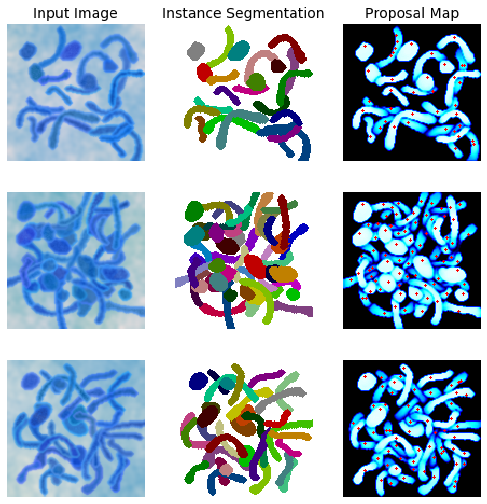

In [11]:
from adaptis.utils.vis import visualize_instances, visualize_proposals


proposals_sampling_params = {
    'thresh1': 0.5,
    'thresh2': 0.5,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 100
}

vis_samples = [15, 25, 42]


fig, ax = plt.subplots(nrows=len(vis_samples), ncols=3, figsize=(7,7))
fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)

for row_indx, sample_indx in enumerate(vis_samples):
    sample = dataset.get_sample(sample_indx)
    pred = get_panoptic_segmentation(pmodel, sample['image'],
                                 sampling_algorithm='proposals',
                                 use_flip=True, **proposals_sampling_params)
    
    for i in range(3):
        ax[row_indx, i].axis('off')

    if row_indx == 0:
        ax[row_indx, 0].set_title('Input Image', fontsize=14)
        ax[row_indx, 1].set_title('Instance Segmentation', fontsize=14)
        ax[row_indx, 2].set_title('Proposal Map', fontsize=14)
    ax[row_indx, 0].imshow(sample['image'])
    ax[row_indx, 1].imshow(visualize_instances(pred['instances_mask']))
    ax[row_indx, 2].imshow(visualize_proposals(pred['proposals_info']))

### Test challenging samples

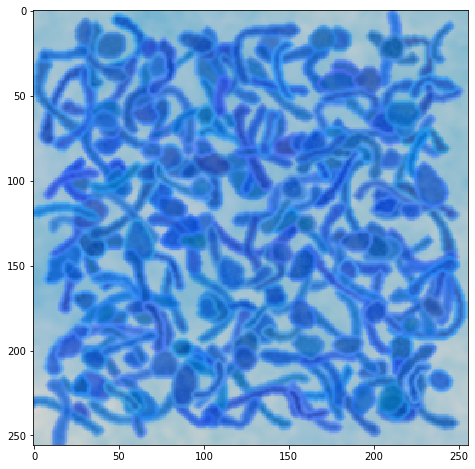

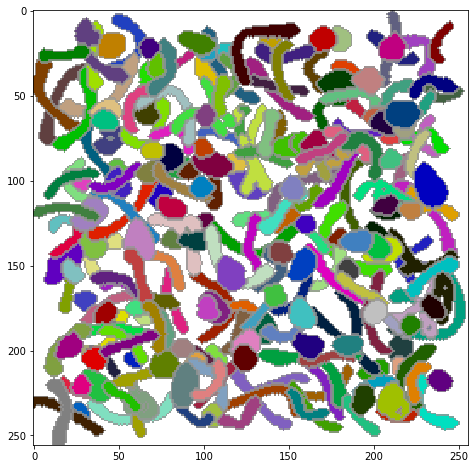

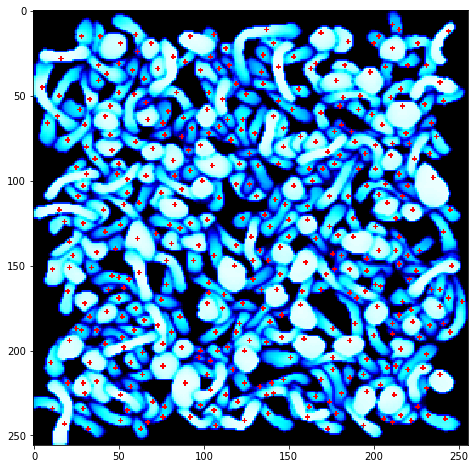

In [12]:
from adaptis.utils.vis import visualize_instances, visualize_proposals

dense_sampling_params = {
    'thresh1': 0.75,
    'thresh2': 0.50,
    'ithresh': 0.3,
    'fl_prob': 0.10,
    'fl_eps': 0.003,
    'fl_blur': 2,
    'max_iters': 1000,
    'cut_radius': 48
}

sample_image = cv2.imread('../images/toy_v2_samples/00000_250_rgb.png')[:, :, ::-1].copy()
plt.figure(figsize=(8, 8))
plt.imshow(sample_image)

pred = get_panoptic_segmentation(pmodel, sample_image,
                                 sampling_algorithm='proposals',
                                 use_flip=True, **dense_sampling_params)

plt.figure(figsize=(8,8))
plt.imshow(visualize_instances(pred['instances_mask'],
                               boundaries_color=(150, 150, 150), boundaries_alpha=0.8))

plt.figure(figsize=(8,8))
plt.imshow(visualize_proposals(pred['proposals_info']))